# AI Automation for AI Fairness

When AI models contribute to high-impact decisions such as whether or
not someone gets a loan, we want them to be fair.
Unfortunately, in current practice, AI models are often optimized
primarily for accuracy, with little consideration for fairness.  This
notebook gives a hands-on example for how AI Automation can help build AI
models that are both accurate and fair.
This notebook is written for data scientists who have some familiarity
with Python. No prior knowledge of AI Automation or AI Fairness is
required, we will introduce the relevant concepts as we get to them.

Bias in data leads to bias in models. AI models are increasingly
consulted for consequential decisions about people, in domains
including credit loans, hiring and retention, penal justice, medical,
and more. Often, the model is trained from past decisions made by
humans. If the decisions used for training were discriminatory, then
your trained model will be too, unless you are careful. Being careful
about bias is something you should do as a data scientist.
Fortunately, you do not have to grapple with this issue alone.  You
can consult others about ethics. You can also ask yourself how your AI
model may affect your (or your institution's) reputation. And
ultimately, you must follow applicable laws and regulations.

_AI Fairness_ can be measured via several metrics, and you need to
select the appropriate metrics based on the circumstances.  For
illustration purposes, this notebook uses one particular fairness
metric called _disparate impact_. Disparate impact is defined as the
ratio of the rate of favorable outcome for the unprivileged group to
that of the privileged group. To make this definition more concrete,
consider the case where a favorable outcome means getting a loan, the
unprivileged group is women, and the privileged group is men.  Then if
your AI model were to let women get a loan in 30% of the cases and men
in 60% of the cases, the disparate impact would be 30% / 60% = 0.5,
indicating a gender bias towards men.  The ideal value for disparate
impact is 1, and you could define fairness for this metric as a band
around 1, e.g., from 0.8 to 1.25.

To get the best performance out of your AI model, you must experiment
with its configuration. This means searching a high-dimensional space
where some options are categorical, some are continuous, and some are
even conditional. No configuration is optimal for all domains let
alone all metrics, and searching them all by hand is impossible. In
fact, in a high-dimensional space, even exhaustively enumerating all
the valid combinations soon becomes impractical.  Fortunately, you can
use tools to automate the search, thus making you more productive at
finding good models quickly. These productivity and quality
improvements become compounded when you have to do the search over.

_AI Automation_ is a technology that assists data scientists in
building AI models by automating some of the tedious steps. One AI
automation technique is _algorithm selection_ , which automatically
chooses among alternative algorithms for a particular task. Another AI
automation technique is _hyperparameter tuning_ , which automatically
configures the arguments of AI algorithms. You can use AI automation
to optimize for a variety of metrics.  This notebook shows you how to use AI
automation to optimize for both accuracy and for fairness as measured
by disparate impact.

This [Jupyter](https://jupyter.org/)
notebook uses the following open-source Python libraries. 
[AIF360](https://aif360.mybluemix.net/) 
is a collection of fairness metrics and bias mitigation algorithms.
The [pandas](https://pandas.pydata.org/) and
[scikit-learn](https://scikit-learn.org/) libraries support
data analysis and machine learning with data structures and a
comprehensive collection of AI algorithms.
The [hyperopt](http://hyperopt.github.io/hyperopt/) library
implements both algorithm selection and hyperparameter tuning for
AI automation.
And [Lale](https://github.com/IBM/lale) is a library for
semi-automated data science; this notebook uses Lale as the backbone
for putting the other libraries together.

Our starting point is a dataset and a task. For illustration
purposes, we picked [credit-g](https://www.openml.org/d/31), also
known as the German Credit dataset. Each row describes a person
using several features that may help evaluate them as a potential
loan applicant. The task is to classify people into either
good or bad credit risks. We load the version of the dataset from
OpenML along with some fairness metadata.

In [1]:
from lale.lib.aif360 import fetch_creditg_df
all_X, all_y, fairness_info = fetch_creditg_df()

Possible set intersection at position 3


To see what the dataset looks like, we can use off-the-shelf
functionality from pandas for inspecting a few
rows.  The creditg dataset has a single label column, `class`, to be
predicted as the outcome, which can be `good` or `bad`. Some of the
feature columns are numbers, others are categoricals.

In [2]:
import pandas as pd
pd.options.display.max_columns = None
pd.concat([all_y, all_X], axis=1)

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,good,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,bad,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,good,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,good,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,bad,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,good,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,4.0,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes
996,good,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,4.0,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes
997,good,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,4.0,car,38.0,none,own,1.0,skilled,1.0,none,yes
998,bad,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,4.0,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes


The `fairness_info` is a JSON object that specifies metadata you
need for measuring and mitigating fairness. The `favorable_labels`
attribute indicates that when the `class` column contains the value
`good`, that is considered a positive outcome.
A _protected attribute_ is a feature that partitions the population
into groups whose outcome should have parity.
Values in the `personal_status` column that indicate that the indidual
is `male` are considered privileged, and so are values in the
`age` column that indicate that the individual is between 26 and 1000
years old.

In [3]:
import lale.pretty_print
lale.pretty_print.ipython_display(fairness_info)

```python
{
    "favorable_labels": ["good"],
    "protected_attributes": [
        {
            "feature": "personal_status",
            "reference_group": [
                "male div/sep", "male mar/wid", "male single",
            ],
        },
        {"feature": "age", "reference_group": [[26, 1000]]},
    ],
}
```

A best practice for any machine-learning experiments is to split
the data into a training set and a hold-out set. Doing so helps 
detect and prevent over-fitting. The fairness information induces
groups in the dataset by outcomes and by privileged groups. We
want the distribution of these groups to be similar for the training
set and the holdout set. Therefore, we split the data in a
stratified way.

In [4]:
from lale.lib.aif360 import fair_stratified_train_test_split
train_X, test_X, train_y, test_y = fair_stratified_train_test_split(
    all_X, all_y, **fairness_info, test_size=0.33, random_state=42)

Let's use the `disparate_impact` metric to measure how biased the
training data and the test data are. At 0.75 and 0.73, they are far
from the ideal value of 1.0.

In [5]:
from lale.lib.aif360 import disparate_impact
disparate_impact_scorer = disparate_impact(**fairness_info)
print("disparate impact of training data {:.2f}, test data {:.2f}".format(
    disparate_impact_scorer.score_data(X=train_X, y_pred=train_y),
    disparate_impact_scorer.score_data(X=test_X, y_pred=test_y)))

disparate impact of training data 0.75, test data 0.73


Before we look at how to train a classifier that is optimized for both
accuracy and disparate impact, we will set a baseline, by training a
pipeline that is only optimized for accuracy. For this purpose, we
import a few algorithms from scikit-learn and Lale:
`Project` picks a subset of the feature columns,
`OneHotEncoder` turns categoricals into numbers,
`ConcatFeatures` combines sets of feature columns,
and the three interpretable classifiers `LR`, `Tree`, and `KNN`
make predictions.

In [6]:
from lale.lib.lale import Project
from sklearn.preprocessing import OneHotEncoder
from lale.lib.lale import ConcatFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN

To use AI Automation, we need to define a _search space_ ,
which is a set of possible machine learning pipelines and
their associated hyperparameters. The following code
uses Lale to define a search space.

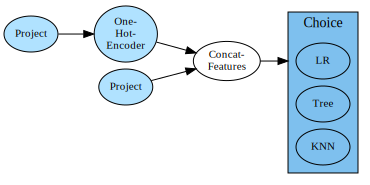

In [7]:
import lale
lale.wrap_imported_operators()
prep_to_numbers = (
    (Project(columns={"type": "string"}) >> OneHotEncoder(handle_unknown="ignore"))
    & Project(columns={"type": "number"})
    ) >> ConcatFeatures
planned_orig = prep_to_numbers >> (LR | Tree | KNN)
planned_orig.visualize()

The call to `wrap_imported_operators` augments the algorithms
that were imported from scikit-learn with metadata about
their hyperparameters.
The Lale combinator `>>` pipes the output from one operator to
the next one, creating a dataflow edge in the pipeline.
The Lale combinator `&` enables multiple sub-pipelines to run
on the same data.
Here, `prep_to_numbers` projects string columns and one-hot encodes them;
projects numeric columns and leaves them unmodified; and
finally concatenates both sets of columns back together.
The Lale combinator `|` indicates
algorithmic choice: `(LR | Tree | KNN)` indicates that
it is up to the AI Automation to decide which of the three different
classifiers to use. Note that the classifiers are
not configured
with concrete hyperparameters, since those will be left for the
AI automation to choose instead.
The search space is encapsulated in the object `planned_orig`.

We will use hyperopt to select the algorithms and to tune their
hyperparameters. Lale provides a `Hyperopt` operator that
turns a search space such as the one specified above into an
optimization problem for the hyperopt tool. After 10 trials, we get back
the model that performed best for the default optimization
objective, which is accuracy.

100%|██████████| 10/10 [00:32<00:00,  3.25s/trial, best loss: -0.7492859812086269]


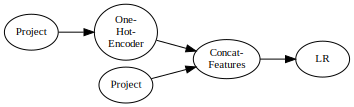

In [8]:
from lale.lib.lale import Hyperopt
best_estimator = planned_orig.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=10)
best_estimator.visualize()

As shown by the visualization, the search found a pipeline
with an LR classifier.
Inspecting the hyperparameters reveals which values
worked best for the 10 trials on the dataset at hand.

In [9]:
best_estimator.pretty_print(ipython_display=True, show_imports=False)

```python
project_0 = Project(columns={"type": "string"})
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
project_1 = Project(columns={"type": "number"})
lr = LR(
    fit_intercept=False,
    intercept_scaling=0.3240599822843736,
    max_iter=839,
    solver="newton-cg",
    tol=0.009200093064280898,
)
pipeline = (
    ((project_0 >> one_hot_encoder) & project_1) >> ConcatFeatures() >> lr
)
```

We can use the accuracy score metric from scikit-learn to measure
how well the pipeline accomplishes the objective for which it
was trained.

In [10]:
import sklearn.metrics
accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(best_estimator, test_X, test_y):.1%}')

accuracy 72.7%


However, we would like our model to be not just accurate but also fair.
We can use the same `disparate_impact_scorer` from before to evaluate
the fairness of `best_estimator`.

In [11]:
print(f'disparate impact {disparate_impact_scorer(best_estimator, test_X, test_y):.2f}')

disparate impact 0.76


The model is biased, which is no surprise, since it was trained
from biased data. We would prefer a
model that is much more fair. The AIF360 toolkit provides several
algorithms for mitigating fairness problems. One of them is
`DisparateImpactRemover`, which modifies the features that are
not the protected attribute in such a way that it is hard to
predict the protected attribute from them. We use a Lale version
of `DisparateImpactRemover` that wraps the corresponding AIF360
algorithm for AI Automation. This algorithm has a hyperparameter
`repair_level` that we will tune with hyperparameter optimization.

In [12]:
from lale.lib.aif360 import DisparateImpactRemover
lale.pretty_print.ipython_display(
    DisparateImpactRemover.hyperparam_schema('repair_level'))

```python
{
    "description": "Repair amount from 0 = none to 1 = full.",
    "type": "number",
    "minimum": 0,
    "maximum": 1,
    "default": 1,
}
```

We compose the bias mitigation algorithm in a pipeline with
a choice of classifiers as before.
In the visualization, light blue indicates trainable operators
and dark blue indicates that automation must make a choice before
the operators can be trained. Compared to the earlier pipeline,
we pass the data preparation sub-pipeline as an argument to `DisparateImpactRemover`,
since that fairness mitigator needs numerical data to work on.

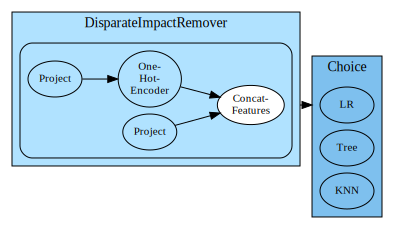

In [13]:
di_remover = DisparateImpactRemover(
    **fairness_info, preparation=prep_to_numbers)
planned_fairer = di_remover >> (LR | Tree | KNN)
planned_fairer.visualize()

Besides changing the planned pipeline to use a fairness mitigation
operator, we should also change the optimization objective. We need
a scoring function that blends accuracy with disparate impact.
While you could define this scorer yourself, Lale also provides a
pre-defined version.

In [14]:
from lale.lib.aif360 import accuracy_and_disparate_impact
combined_scorer = accuracy_and_disparate_impact(**fairness_info)

Fairness metrics can be more unstable than accuracy, because they depend
not just on the distribution of labels, but also on the distribution of
privileged and unprivileged groups as defined by the protected attributes.
In AI Automation, k-fold cross validation helps reduce overfitting.
To get more stable results, we will stratify these k folds by both labels
and groups.

In [15]:
from lale.lib.aif360 import FairStratifiedKFold
fair_cv = FairStratifiedKFold(**fairness_info, n_splits=3)

Now, we have all the pieces in place to use AI Automation
on our `planned_fairer` pipeline for both accuracy and
disparate impact.

In [16]:
trained_fairer = planned_fairer.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=fair_cv,
    max_evals=10, scoring=combined_scorer, best_score=1.0)

100%|██████████| 10/10 [01:23<00:00,  8.39s/trial, best loss: 0.15000066730728168]


As with any trained model, we can evaluate and visualize the result.

accuracy 71.2%
disparate impact 1.00


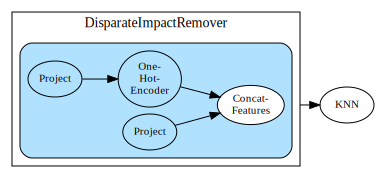

In [17]:
print(f'accuracy {accuracy_scorer(trained_fairer, test_X, test_y):.1%}')
print(f'disparate impact {disparate_impact_scorer(trained_fairer, test_X, test_y):.2f}')
trained_fairer.visualize()

As the result demonstrates, the best model found by AI Automation
has similar accuracy and better disparate impact than the one we saw
before. Also, it has tuned the repair level and
has picked and tuned a classifier.

In [18]:
trained_fairer.pretty_print(ipython_display=True, show_imports=False)

```python
project = Project(columns={"type": "string"})
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
project_0 = Project(columns={"type": "number"})
disparate_impact_remover = DisparateImpactRemover(
    favorable_labels=["good"],
    protected_attributes=[
        {
            "reference_group": [
                "male div/sep", "male mar/wid", "male single",
            ],
            "name": "lale.lib.aif360.disparate_impact_remover.DisparateImpactRemover",
            "feature": "personal_status",
        },
        {
            "feature": "age",
            "reference_group": [[26, 1000]],
            "name": "lale.lib.aif360.disparate_impact_remover.DisparateImpactRemover",
        },
    ],
    preparation=((project >> one_hot_encoder) & project_0)
    >> ConcatFeatures(),
    repair_level=0.6701479482689345,
)
knn = KNN(algorithm="ball_tree", metric="manhattan", n_neighbors=93)
pipeline = disparate_impact_remover >> knn
```

These results may vary by dataset and search space.

In summary, this blog post showed you how to use AI Automation
from Lale, while incorporating a fairness mitigation technique
into the pipeline and a fairness metric into the objective.
Of course, this blog post only scratches the surface of what can
be done with AI Automation and AI Fairness. We encourage you to
check out the open-source projects Lale and AIF360 and use them
to build your own fair and accurate models!

- Lale: https://github.com/IBM/lale
- AIF360: https://aif360.mybluemix.net/
- API documentation: [lale.lib.aif360](https://lale.readthedocs.io/en/latest/modules/lale.lib.aif360.html#module-lale.lib.aif360)